# Predicting Condo prices in Sao Paulo

### Objective
Our main goal is to building a machine learning model for predicting condo price in Sao Paulo to help real state investors to make better business decisions.

- Build a simple regression model for predicting land prices in Sao Paulo.
- Improve prediction model by adding data through the Foursquare API.

## 1. Description of the data
The main data used for this project will be from two sources:
- The rent/sale condo price in Sao Paulo. (Kaggle)
- The venues in each neighborhood. (FourSquare API)

<a href='https://www.kaggle.com/argonalyst/sao-paulo-real-estate-sale-rent-april-2019'>Link to kaggle Dataset</a>

### Limitations
- Due to limited calling API from Foursquare each times, we can't use all sale data from the original(6412rows) so in this project, we will focus on recent property marked as 'New' = 1 in the original dataset.

### Columns

- PriceFinal price advertised (R$ Brazilian Real)
- CondoCondominium expenses (unknown values are marked as zero)
- SizeThe property size in Square Meters m² (private areas only)
- RoomsNumber of bedrooms
- ToiletsNumber of toilets (all toilets)
- SuitesNumber of bedrooms with a private bathroom (en suite)
- ParkingNumber of parking spots
- ElevatorBinary value: 1 if there is elevator in the building, 0 otherwise
- FurnishedBinary value: 1 if the property is funished, 0 otherwise
- Swimming PoolBinary value: 1 if the property has swimming pool, 0 otherwise
- NewBinary value: 1 if the property is very recent, 0 otherwise
- DistrictThe neighborhood and city where the property is located, e.i: Itaim Bibi/São Paulo
- Negotiation TypeSale or Rent
- Property TypeThe property type
- Latitude
- Longitude

In [166]:

!conda install -c conda-forge beautifulsoup4 --yes

!conda install -c conda-forge geopy --yes

!conda install -c conda-forge folium=0.5.0 --yes

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.



## 2.import libraries and Dataset

In [167]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests

import folium
import locale

In [168]:
df = pd.read_csv('https://raw.githubusercontent.com/terterter333/Coursera_Capstone/master/sao-paulo-properties-april-2019.csv')
df.head()

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District,Negotiation Type,Property Type,Latitude,Longitude
0,930,220,47,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.543138,-46.479486
1,1000,148,45,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.550239,-46.480718
2,1000,100,48,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.542818,-46.485665
3,1000,200,48,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.547171,-46.483014
4,1300,410,55,2,2,1,1,1,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.525025,-46.482436


In [169]:
df.shape

(13640, 16)

Clean data and select recent condos 

In [170]:
df=df[df["Negotiation Type"]=='sale']
#df = df[condition]
df = df[df["Latitude"] != 0]
df = df[df["New"] == 1]
print(df.shape)
df= df.reset_index(drop = True)

df.head()

(196, 16)


,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District,Negotiation Type,Property Type,Latitude,Longitude
0,720000,700,70,2,2,1,1,1,0,1,1,Vila Madalena/São Paulo,sale,apartment,-23.547687,-46.692594
1,650000,0,67,2,2,1,1,1,0,0,1,Vila Madalena/São Paulo,sale,apartment,-23.562150,-46.692518
2,441000,550,69,2,2,1,2,1,0,1,1,Mooca/São Paulo,sale,apartment,-23.559428,-46.603770
3,345300,0,58,3,2,0,1,1,0,0,1,Mooca/São Paulo,sale,apartment,-23.549321,-46.583944
4,880000,0,118,3,4,3,2,1,0,1,1,Mooca/São Paulo,sale,apartment,-23.558443,-46.593451


In [171]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196 entries, 0 to 195
Data columns (total 16 columns):
Price               196 non-null int64
Condo               196 non-null int64
Size                196 non-null int64
Rooms               196 non-null int64
Toilets             196 non-null int64
Suites              196 non-null int64
Parking             196 non-null int64
Elevator            196 non-null int64
Furnished           196 non-null int64
Swimming Pool       196 non-null int64
New                 196 non-null int64
District            196 non-null object
Negotiation Type    196 non-null object
Property Type       196 non-null object
Latitude            196 non-null float64
Longitude           196 non-null float64
dtypes: float64(2), int64(11), object(3)
memory usage: 24.6+ KB


## 3. Foursquare data
The idea is very simple: we define a function to search number of venues near a piece of land. Then we add it to our features and train a multi-linear regression model.

In [172]:
CLIENT_ID = 'OCCG4XFVYRYZAY1YG24SQYAXL04SGDXLH5ELUMNHDNZK2AVH' # your Foursquare ID
CLIENT_SECRET = 'XNMQOAINHXANPHLM01SYVJGOG3GRUEUCVAZ2O1NWNNFJTD1U' # your Foursquare Secret
VERSION = '20190909' # Foursquare API version

LIMIT = 100
radius = 300

define the function for calculating numbers of near venues 

In [173]:
def venues_near(lat, long):

    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        lat, 
        long, 
        radius, 
        LIMIT)
    
    results = requests.get(url).json()
    venues = results['response']['groups'][0]['items']
    
    return len(venues)

add to the original dataframe

In [174]:
for i in range(df.shape[0]-1):
    df.loc[i, 'venues_near'] = venues_near(df['Latitude'][i], df['Longitude'][i])

## 4. Explore

In [175]:
import seaborn as sns

In [180]:
df.head()

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District,Negotiation Type,Property Type,Latitude,Longitude,venues_near
0,720000,700,70,2,2,1,1,1,0,1,1,Vila Madalena/São Paulo,sale,apartment,-23.547687,-46.692594,32.0
1,650000,0,67,2,2,1,1,1,0,0,1,Vila Madalena/São Paulo,sale,apartment,-23.562150,-46.692518,56.0
2,441000,550,69,2,2,1,2,1,0,1,1,Mooca/São Paulo,sale,apartment,-23.559428,-46.603770,13.0
3,345300,0,58,3,2,0,1,1,0,0,1,Mooca/São Paulo,sale,apartment,-23.549321,-46.583944,6.0
4,880000,0,118,3,4,3,2,1,0,1,1,Mooca/São Paulo,sale,apartment,-23.558443,-46.593451,24.0


In [182]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196 entries, 0 to 195
Data columns (total 17 columns):
Price               196 non-null int64
Condo               196 non-null int64
Size                196 non-null int64
Rooms               196 non-null int64
Toilets             196 non-null int64
Suites              196 non-null int64
Parking             196 non-null int64
Elevator            196 non-null int64
Furnished           196 non-null int64
Swimming Pool       196 non-null int64
New                 196 non-null int64
District            196 non-null object
Negotiation Type    196 non-null object
Property Type       196 non-null object
Latitude            196 non-null float64
Longitude           196 non-null float64
venues_near         196 non-null float64
dtypes: float64(3), int64(11), object(3)
memory usage: 26.1+ KB


In [184]:
df.corr()

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,Latitude,Longitude,venues_near
Price,1.000000,0.458293,0.834325,0.654590,0.519361,0.405709,0.577019,NaN,0.000887,0.261181,NaN,0.038552,-0.064869,0.359275
Condo,0.458293,1.000000,0.486736,0.332831,0.509596,0.645213,0.292174,NaN,0.034637,0.144820,NaN,0.046614,-0.020767,0.271242
Size,0.834325,0.486736,1.000000,0.815055,0.586768,0.429887,0.698163,NaN,-0.030611,0.285181,NaN,0.068155,-0.021531,0.250601
Rooms,0.654590,0.332831,0.815055,1.000000,0.555090,0.302400,0.580697,NaN,-0.113508,0.234431,NaN,0.027044,-0.024436,0.073484
Toilets,0.519361,0.509596,0.586768,0.555090,1.000000,0.740796,0.478346,NaN,0.013705,0.419114,NaN,0.083005,-0.028350,0.228752
Suites,0.405709,0.645213,0.429887,0.302400,0.740796,1.000000,0.340912,NaN,0.035290,0.327395,NaN,0.077997,-0.021571,0.236817
Parking,0.577019,0.292174,0.698163,0.580697,0.478346,0.340912,1.000000,NaN,0.117773,0.356012,NaN,0.024617,-0.032525,0.101890
Elevator,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Furnished,0.000887,0.034637,-0.030611,-0.113508,0.013705,0.035290,0.117773,NaN,1.000000,0.092601,NaN,0.017815,0.014947,0.076902
Swimming Pool,0.261181,0.144820,0.285181,0.234431,0.419114,0.327395,0.356012,NaN,0.092601,1.000000,NaN,0.094742,-0.060006,0.200991


- From pearson correlation table above,We can clearly see that 'Size' affect 'Price' significantly.
- 'Rooms' 'Parking' and 'venues_near' seem slightly affect 'Price'.

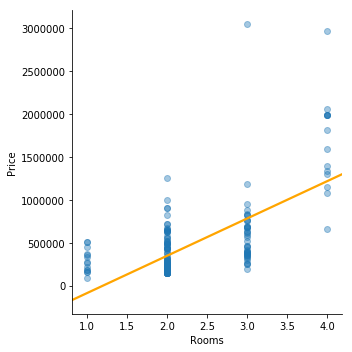

In [185]:
sns.lmplot(x="Rooms",y="Price",data=df,ci=None,
          scatter_kws={'alpha':0.4},line_kws={'color':'orange'})

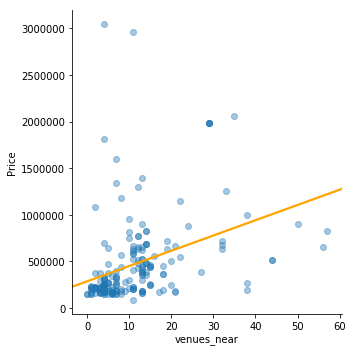

In [225]:
sns.lmplot(x="venues_near",y="Price",data=df,ci=None,
          scatter_kws={'alpha':0.4},line_kws={'color':'orange'})

## 5.Multiple Linear Regression

model1 : we use 'Size', 'Rooms','Parking' as features 

model2 : Let's take 'venues_near' into account

In [186]:
df.columns

Index(['Price', 'Condo', 'Size', 'Rooms', 'Toilets', 'Suites', 'Parking',
       'Elevator', 'Furnished', 'Swimming Pool', 'New', 'District',
       'Negotiation Type', 'Property Type', 'Latitude', 'Longitude',
       'venues_near'],
      dtype='object')

In [187]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error
from sklearn import metrics
from sklearn.metrics import r2_score

### Model1

In [213]:
X = df[['Size', 'Rooms','Parking']]
y = df['Price']

In [214]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model1 = LinearRegression()
model1.fit(X_train,y_train)

y_pred = model1.predict(X_test)

'RMSLE: %.2f' % np.sqrt(mean_squared_log_error(y_test, y_pred))

'RMSLE: 0.23'

In [215]:
y_pred = model1.predict(X_test)
'R^2: %.3f' % r2_score(y_test, y_pred)

'R^2: 0.897'

In [216]:
df1 = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df1.head(5)

,Actual,Predicted
139,655500,537270.276195
113,150900,204272.276682
16,590000,883993.629807
75,184900,204272.276682
154,550000,699286.956374


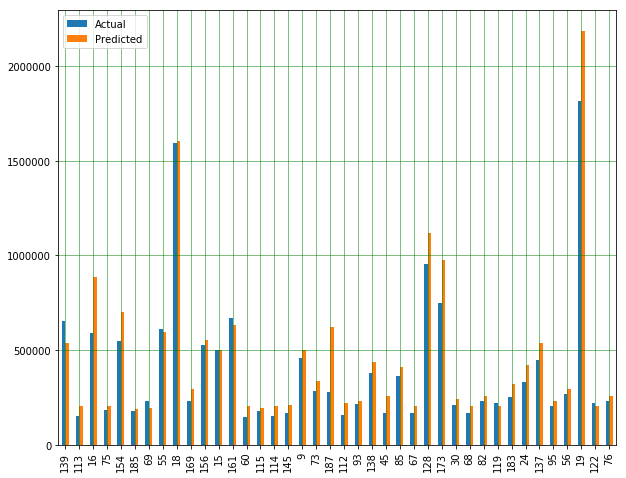

In [217]:
df1.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [218]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 73720.44602496589
Mean Squared Error: 13160500765.816427
Root Mean Squared Error: 114719.22578982316


### Model2 (add venue near)

In [219]:
X = df[['Size', 'Rooms','Parking','venues_near']]
y = df['Price']

In [220]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model2 = LinearRegression()
model2.fit(X_train,y_train)

y_pred = model2.predict(X_test)

'RMSLE: %.2f' % np.sqrt(mean_squared_log_error(y_test, y_pred))

'RMSLE: 0.22'

In [221]:
y_pred = model2.predict(X_test)
'R^2: %.3f' % r2_score(y_test, y_pred)

'R^2: 0.932'

In [222]:
df2 = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df2.head(5)

,Actual,Predicted
139,655500,545308.629411
113,150900,145045.881790
16,590000,865230.277156
75,184900,233610.231620
154,550000,717827.746436


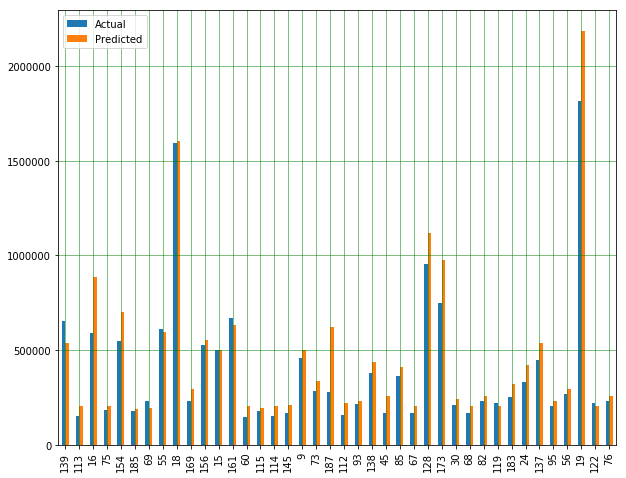

In [223]:
df1.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [224]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 66671.74358373118
Mean Squared Error: 8703312256.41301
Root Mean Squared Error: 93291.54439933455


## 6. Conclusion

Result
#### Model1
- R Square = 0.897
- MSE = 13,160,500,765.816427
- RMSE = 114,719.22578982316

#### Model2 (add near venues) 
- R Square = 0.932
- MSE = 8,703,312,256.41301
- RMSE = 93,291.54439933455

From results above,we can conclude that model2 is better than model1.

## 7.Further Development

The following are suggestions how this project could be further developed:

- Due to Foursqure limitation in this project,we should use all the dataset(6412rows) from kaggle for building a model.
- Due to wealth difference of each districts in sao paulo,we should categorize the wealth level and then create a model based on each wealth level.
- Find the other features that may affect the condo price for better accuracy.For example,How old,facility rating from resident,etc.

